#Image De-noising with Autoencoder
![picture](https://drive.google.com/uc?export=view&id=1MywEsuJouQortjNckxDGggY7x9CY5CPe)

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np



#Parameters

In [ ]:
# Model configuration
img_width, img_height = 28, 28
batch_size = 150
no_epochs = 5
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.55
number_of_visualizations = 6

# Load MNIST dataset

![picture](https://drive.google.com/uc?export=view&id=1_5zXQV0KB5jwr-1_Ae6GSK2MOwwL_NL-)

In [ ]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


#Prepare the data for the network
We prepare data in (N,1,rows,cols) or (N,rows,cols,1)

In [ ]:

input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 1)
input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 1)
input_shape = (img_width, img_height, 1)
    
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

#Data Normalization

In [ ]:


# Normalize data
input_train = input_train / 255
input_test = input_test / 255

#Prepare the noisy data

In [ ]:
pure = input_train # Ground truths
pure_test = input_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise # Noisy input image
noisy_input_test = pure_test + noise_factor * noise_test


#The network

Here we use a new layer: **Conv2DTranspose** \\

A simple way to think about it is that it both performs the upsample operation and interprets the coarse input data to fill in the detail while it is upsampling. It is like a layer that combines the UpSampling2D and Conv2D layers into one layer. This is a crude understanding, but a practical starting point.
![picture](https://drive.google.com/uc?export=view&id=1BQsnhdEPvoVbY4IpoOpkIBrmsS-rv3zb)

[Find more details at](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8)


In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2DTranspose(32, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2DTranspose(64, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(1, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         577       
Total params: 47,425
Trainable params: 47,425
Non-trainable params: 0
_________________________________________________________________


# Plot the model

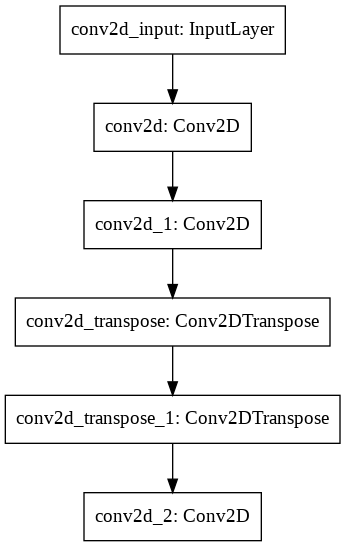

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png')

# Loss function and optimizer
Optimizer  is Adam \\

Loss is binary cross entropy: computed for each pixel location

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(noisy_input, pure,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load the trained model

In [ ]:
trainedModel = keras.models.load_model('/content/drive/My Drive/Autoencoders/Denoisingmodel')

#Generate de-noise images

In [ ]:
# Noisy test images
samples = noisy_input_test[:number_of_visualizations]

#Ground-truth images
targets = target_test[:number_of_visualizations]

#Denoised Images
denoised_images = trainedModel.predict(samples)

#Plot the images

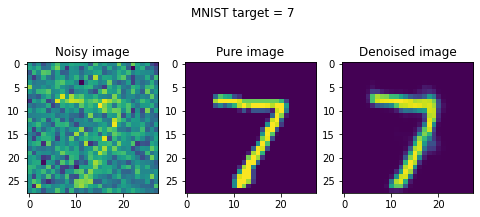

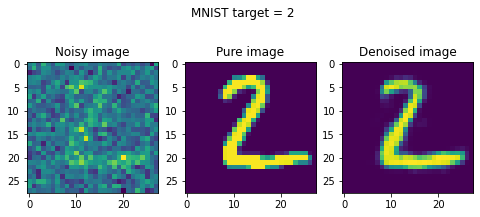

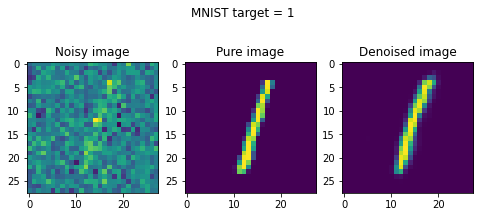

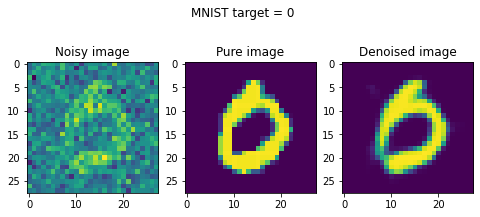

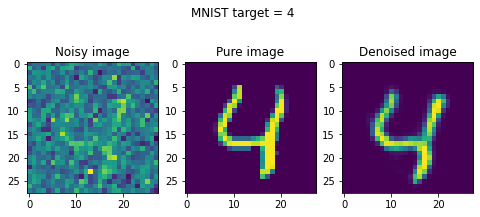

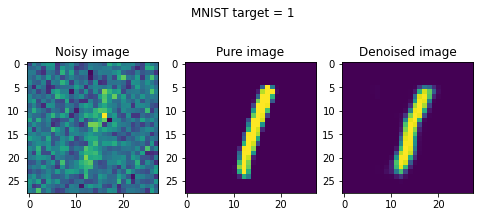

In [ ]:
# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i][:, :, 0]
  pure_image  = pure_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(8, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  fig.suptitle(f'MNIST target = {input_class}')
  plt.show()